# 操作変数法




## 概要

観察データから結果変数$Y$への処置$X$の効果を測りたい場合、共変量$U$をコントロールしない限り、推定量に欠落変数バイアスを生じさせる。

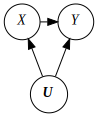

In [ ]:
import graphviz
graphviz.Source("""
digraph g {
    graph [rankdir = TB];
    node[shape = circle];
        X [label=<<I>X</I>>]
        Y [label=<<I>Y</I>>]
        U [label=<<B><I>U</I></B>>]
    edge [];    
        X -> Y
        U -> {X,Y}
    {rank = max U}
    {rank = same X;Y}
    
}
""")

他の変数から独立して処置$X$を通じてのみ$Y$に影響を与える$Z$のような変数があれば、これを利用することで$X\to Y$の因果効果を識別することが可能になる。この場合の$Z$のような変数を**操作変数**（instrmental variable: IV）と呼ぶ。

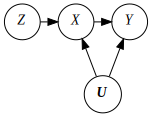

In [ ]:
import graphviz
graphviz.Source("""
digraph g {
    graph [rankdir = TB];
    
    node[shape = circle];
    X [label=<<I>X</I>>]
    Y [label=<<I>Y</I>>]
    Z [label=<<I>Z</I>>]
    U [label=<<B><I>U</I></B>>]
    edge [];    
    Z -> X -> Y
    U -> {X,Y}
    {rank = max U}
    {rank = same Z;X;Y}
    
}
""")

## 操作変数法の推定方法

2つの方法がある

1. $Z \to Y$の因果効果と$Z\to X$の因果効果を割って推定する
2. 二段階最小二乗法

どちらのアプローチでも同じ推定結果を得ることができる。


## データの生成



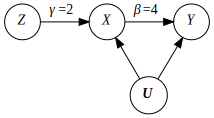

In [3]:
import graphviz
graphviz.Source("""
digraph g {
    graph [rankdir = TB];
    
    node[shape = circle];
    X [label=<<I>X</I>>]
    Y [label=<<I>Y</I>>]
    Z [label=<<I>Z</I>>]
    U [label=<<B><I>U</I></B>>]
    edge [];
    Z -> X [label=<<I>γ</I>=2>]
    X -> Y [label=<<I>β</I>=4>]
    U -> {X,Y}
    {rank = max U}
    {rank = same Z;X;Y}
    
}
""")

In [4]:
import numpy as np
import pandas as pd

gamma = 2
beta = 4

n = 500
np.random.seed(0)
u = np.random.uniform(low=0, high=1, size=n)
z = np.random.uniform(low=-1, high=1, size=n)
x = 10 + gamma * z + 5 * u + np.random.normal(size=n)
y = 5 + beta * x + 5 * u + np.random.normal(scale=2, size=n)

df = pd.DataFrame(dict(y=y, x=x, z=z, u=u))
df.round(1).head()

,y,x,z,u
0,52.1,11.9,-0.4,0.5
1,65.4,13.1,-0.3,0.7
2,65.0,15.0,0.0,0.6
3,65.6,13.5,0.5,0.5
4,46.7,11.0,-0.3,0.4


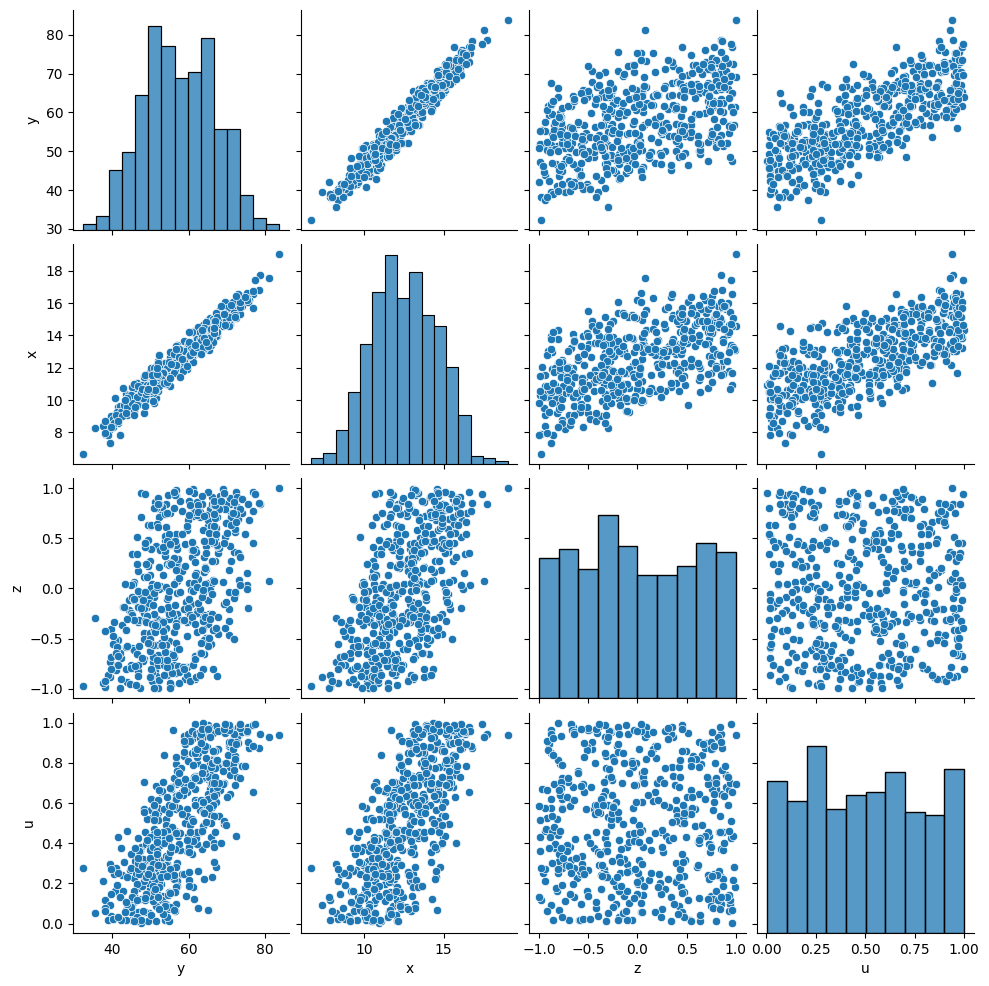

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df)
plt.show()

### そのまま推定した場合

次のような単回帰モデルを考える

$$
Y = \beta_0 + \beta_1 X + \varepsilon
$$

説明変数は$X$のみで、$E[\varepsilon]= 0$とする。

回帰係数$\beta_0, \beta_1$を正しく推定するためには、説明変数の外生性が重要な条件となる。

説明変数が外生変数であるとき$E[X, \varepsilon]=Cov(X, \varepsilon)=0$が成立するので、

$$
\beta_1 = \frac{Cov(X, Y)}{Var(X)} \tag{1}
$$

となる。


説明変数が内生変数である場合、

$$
E[X, \varepsilon]=Cov(X, \varepsilon) \neq 0
$$

から

$$
Cov(X, Y) = Var(X) \beta_1 + Cov(X, \varepsilon)
$$

から、$(1)$式の右辺は

$$
\beta_1 + 
\underbrace{ \frac{Cov(X, \varepsilon)}{Var(X)} }_{内生変数バイアス} \neq \beta_1
$$

となる

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

models = [
    smf.ols('y ~ x', data=df).fit(),
    smf.ols('y ~ x + z', data=df).fit(),
    smf.ols('y ~ x + u', data=df).fit(),
]
Stargazer(models)

## 方法1：$Z \to Y$の因果効果と$Z\to X$の因果効果を割って推定する

$$
Z \to Y \text{の因果効果}
= \frac{
    Z \to Y \text{の因果効果}
}{
    Z \to X \text{の因果効果}
}
$$

であるため、$Z \to Y$の因果効果と$Z\to X$の因果効果を割って推定する。

$X\to Y$の因果効果を$\beta$、$Z\to X$の因果効果を$\gamma$とおくと、$Z\to Y$の因果効果はその積$\beta \times \gamma$になる。

そのため

$$
\beta = \frac{\beta \times \gamma}{\gamma}
$$

で推定するということ。

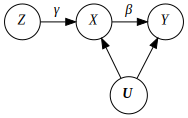

In [7]:
import graphviz
graphviz.Source("""
digraph g {
    graph [rankdir = TB];
    
    node[shape = circle];
    X [label=<<I>X</I>>]
    Y [label=<<I>Y</I>>]
    Z [label=<<I>Z</I>>]
    U [label=<<B><I>U</I></B>>]
    edge [];
    Z -> X [label=<<I>γ</I>>]
    X -> Y [label=<<I>β</I>>]
    U -> {X,Y}
    {rank = max U}
    {rank = same Z;X;Y}
    
}
""")

$Z\to X$の検証を**第一段階**（first stage）の検証、$Z\to Y$の検証を**誘導型**（reduced form）の検証という。

- 第一段階：$X = \gamma_0 + \gamma_1 Z + e$
- 誘導型：$Y = \pi_0 + \pi_1 Z + v$

:::{margin}
第1段階を誘導型と呼ぶこともある。
もともとマクロモデルのような同時方程式において内生変数の方程式を解いてモデルの右側を外生変数のみにした形のモデルを「誘導型」と呼んでいたため。
:::

In [8]:
from patsy import dmatrices

y, X = dmatrices("x ~ z", data=df, return_type="dataframe")
model1 = sm.OLS(y, X).fit()
model1.params

Intercept    12.537640
z             1.981999
dtype: float64

In [9]:
y, X = dmatrices("y ~ z", data=df, return_type="dataframe")
model2 = sm.OLS(y, X).fit()
model2.params

Intercept    57.638072
z             7.716850
dtype: float64

In [10]:
model2.params / model1.params

Intercept    4.597203
z            3.893468
dtype: float64

## 方法2：二段階最小二乗法

$X$の変動のうち$Z$の変動に起因する変動分$\hat{X}$を推定し、その後$\hat{X}\to Y$の因果効果を推定する（それにより$U$に起因する$X$の変動を除く）

### 第一段階

$X$を$Z$に回帰する（$e$は誤差項）

$$
X = \gamma_0 + \gamma_1 Z + e
$$

$X$の予測値$\hat{X}$を得る

$$
\hat{X} = \hat{\gamma}_0 + \hat{\gamma}_1 Z
$$


### 第二段階

$X$を$\hat{X}$に置き換えて回帰分析を行う

$$
Y = \beta_0 + \beta_1 \hat{X} + \varepsilon
$$

この推定量は**二段階最小二乗（two-stage least squares: TSLS）推定量**と呼ばれる。

:::{margin}
$U$も$Z$も使わずに

$$
Y = \beta_0 + \beta_1 X + \epsilon
$$

のようにモデルを立てて推定すると、欠落変数バイアスが生じ、$X$と$\epsilon$は相関する（$X$で説明しきれなかった部分に$X$と相関する$U$に起因する変動が残るため）

しかし、$U$と相関しない$Z$の変動を使った$\hat{X}$は$U$と相関しないため、$\hat{X}$と$\varepsilon$は相関しない
:::


単回帰かつ操作変数が1つの場合のTSLS推定量は

$$
\hat{\beta}^{TSLS}_1
= \frac{ ZとYの標本共分散 }{ ZとXの標本共分散 }
$$

となる。

### OLSを用いてTSLSを行う

IV系のパッケージを使わずに推定する方法。TSLS推定値は得られるが標準誤差の推定はできない。

In [11]:
y, X = dmatrices("x ~ z", data=df, return_type="dataframe")
model1 = sm.OLS(y, X).fit()
model1.params

Intercept    12.537640
z             1.981999
dtype: float64

In [12]:
x_hat = model1.predict(X)

In [13]:
y, X = dmatrices("y ~ x_hat", data=df.assign(x_hat=x_hat), return_type="dataframe")
model2 = sm.OLS(y, X).fit()
Stargazer([model2])

### TSLS

専用のメソッドを用いる方法。標準誤差も適切に推定できるはずだが、statsmodelsのIV2SLSはバグってる様子

In [15]:
from statsmodels.sandbox.regression.gmm import IV2SLS

y, X = dmatrices("y ~ x", data=df, return_type="dataframe")
result = IV2SLS(y, X, instrument=df["z"]).fit()
result.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                  -14101.824
Model:                         IV2SLS   Adj. R-squared:             -14130.143
Method:                     Two Stage   F-statistic:                -8.392e-17
                        Least Squares   Prob (F-statistic):               1.00
Date:                Sat, 20 May 2023                                         
Time:                        11:22:08                                         
No. Observations:                 500                                         
Df Residuals:                     498                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -904.5164        nan        nan        nan         nan         nan
x            -12.0000        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                        8.687   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                5.330
Skew:                           0.050   Prob(JB):                       0.0696
Kurtosis:                       2.504   Cond. No.                         78.1
==============================================================================
"""

In [20]:
from linearmodels.iv import IV2SLS
model = IV2SLS.from_formula("y ~ [x ~ z]", df).fit()
model

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.9641
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9640
No. Observations:                 500   F-statistic:                    50.264
Date:                Sat, May 20 2023   P-value (F-stat)                0.0000
Time:                        13:07:38   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
x              3.7399     0.5275     7.0897     0.0000      2.7060      4.7738
==============================================================================

Endogenous: x
Instruments: z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f1be4895550

## 例

### 学習効果

[Stinebrickner, T. R., & Stinebrickner, R. (2007). The causal effect of studying on academic performance (Working Paper No. 13341). National Bureau of Economic Research. Retrieved April, 23, 2015.](https://www.nber.org/papers/w13341)

方法

- $Y$：最初のセメスターのGPA
- $X$：1日あたりの平均勉強時間
- $Z$：ルームメイトがビデオゲームを買ったら$Z=1$、買わなかったら$Z=0$
  - ルームメイトはランダムに割り当てられる
- $n=210$
  - 対象は Berea College の大学1年生（2001年）

結果

- IV（TSLS）推定量：$0.360$
- 勉強時間が1時間減ったことによるGPAの減少幅は0.36ポイント

## 操作変数法の推定量の特性

### 操作変数の妥当性の条件

次の2つの条件を満たす操作変数$Z$が必要

1. 操作変数の**関連性**：$corr(Z, X) \neq 0$
2. 操作変数の**外生性**：$corr(Z, \varepsilon) = 0$

### TSLS推定量の一致性

関連性と外生性が満たされるとき、TSLS推定量は一致性をもつ。

:::{card} （証明）
単回帰モデルにおけるTSLS推定量

$$
\hat{\beta}_1^{TSLS}
= \frac{ ZとYの標本共分散 }{ ZとXの標本共分散 }\\
= \frac{ s_{Z, Y} }{ s_{Z, X} }\\
$$

を例にとる。

推定モデル$Y = \beta_0 + \beta_1 X + \varepsilon$より、

$$
\begin{align}
Cov(Z, Y)
&= Cov(Z, \beta_0 + \beta_1 X + \varepsilon)\\
&= Cov(Z, \beta_0) + Cov(Z, \beta_1 X) + Cov(Z, \varepsilon)\\
&= 0 + Cov(Z, \beta_1 X) + 0\\
&= \beta_1 Cov(Z, X)
\end{align}
$$

したがって

$$
\beta_1 = \frac{ Cov(Z, Y) }{ Cov(Z, X) }
$$

標本による推定量$\hat{\beta}_1^{TSLS}$は母集団の共分散$Cov(Z, Y), Cov(Z, X)$を標本の共分散$s_{Z, Y}, s_{Z, X}$に置き換えたものであり、標本サイズが大きくなれば$\beta_1$に近づく

$$
\hat{\beta}_1^{TSLS} = \frac{ s_{Z, Y} }{ s_{Z, X} }
\to \frac{ Cov(Z, Y) }{ Cov(Z, X) }
$$

:::


### TSLS推定量の標準誤差

二段階最小二乗法を行う場合、二段階目のOLS推定量の標準誤差は正しくない（第一段階で推定した予測値を用いていることの考慮がされていないため）

実際に使うときは手作業で二段階最小二乗法を行うのではなく、統計分析ソフトに任せるほうがよい（更にいうと不均一分散に対して頑健な標準誤差を使うのがよい）


漸近的に（大規模標本では）、TSLSを推定量の標本分布は正規分布$N(\beta_1, \sigma^2_{\hat{\beta}_1^{TSLS}})$に従う。

$$
\sigma^2_{\hat{\beta}_1^{TSLS}}
= \frac{1}{n}
\frac{ Var[(Z-E[Z])\mu] }{ Cov(Z, X)^2 }
$$

（S&W、App. 12.3）



## ワルド推定量

単回帰モデル$Y=\beta_0 + \beta_1 X + \varepsilon$を想定する。

Xは内生変数$E(\varepsilon|X)\neq 0$とする。

次の条件を満たす操作変数$Z$があるとする。

- ダミー変数である：$Z \in \{0, 1\}$
- 外生性を満たす：$E(\varepsilon|Z)=0$
- 関連性を満たす：$E(X|Z) \neq 0$


$\beta_1$は次の2つのモデルを用いて推定することができる

- 第一段階：$X = \pi_0 + \pi_1 Z + v$
- 誘導形：$Y = \gamma_0 + \gamma_1 Z + w$

$$
\beta_1 = \frac{
    E(Y|Z=1) - E(Y|Z=0)
}{
    E(Y|X=1) - E(Y|X=0)
}
= \frac{\gamma_1}{\pi_1}
$$

上記の方法による推定量を**ワルド推定量**（Wald estimator）と呼ぶ。

## LATE

操作変数は母集団全体ではなく特定のサブグループの処置割り当てに影響を与える事が多い

→ IV推定量は「母集団全体の平均処置効果」ではなく、「操作変数の変動の影響を受けるサブグループの処置効果」を捉えている

このような推定量の解釈として、**局所的平均処置効果**（local average treatment effect: **LATE**）という概念がある



### 誰が操作変数の影響を受けるか？

操作変数も処置変数も二値変数のケースでは、処置変数$D$の操作変数$Z$についての潜在的結果$D(Z)$の組み合わせは4パターンになる

- Always-Taker: $Z$がなんであれ必ず$D=1$
- Never-Taker: $Z$がなんであれ必ず$D=0$
- Complier: $Z=1$ならば$D=1$を選択し、$Z=0$ならば$T=0$を選択
- Defier: $Z=0$ならば$D=1$を選択し、$Z=1$ならば$=0$を選択


$$
T = 
\begin{cases}
    \text{never-taker} & \text{ if } D(0) = D(1) = 0\\
    \text{complier} & \text{ if } D(0) = D(1) = 1\\
    \text{defier} & \text{ if } D(1) = D(1) = 0\\
    \text{always-taker} & \text{ if } D(0) = D(1) = 0\\
\end{cases}
$$



### LATE

1. 独立性（independence)：$\newcommand{\indep}{\mathop{\hspace{0.1em} \perp\!\!\!\perp \hspace{0.1em}}} \{Y(0), Y(1), D(0), D(1)\} \indep Z$
2. 除外制約（exclusion restriction）：$Z$から$Y$への影響は$D$を通じてのみ存在
3. 関連性（relevance）：$Z$は$D$に影響を与えうる：$E[D(1)-D(0)]\neq 0$
4. 単調性（monotonicity）：$D(1)-D(0) \geq 0 \text{for all} i, \text{or vice versa}$（no defier）

上記の4つの仮定が成り立つとき、

$$
\begin{align}
\beta_{1, Wald}
&= \frac{ E(Y|Z=1) - E(Y|Z=0) }{ E(D|Z=1) - E(D|Z=0) }\\
&= E[Y(1) - Y(0)|T=complier]\\
&= \beta_{1, LATE}
\end{align}
$$

となる

:::{dropdown} 証明

:::

#### LATEの意味

IV推定量は、操作変数によって処置変数の状況が変わるグループ（complier）における平均処置効果を捉える

$$
\beta_{1, LATE} = E[Y(1) - Y(0)|T=complier]
$$

Complierか否かは観測不可能→LATEは観測不可能なグループについての因果効果

操作変数が異なればLATEも異なる

外的妥当性については常に留意が必要

### ITTとLATE

実験（RCT）において、処置をランダムに割り当てても、処置に従わない人たち（non-complier）もいる

**intention-to-treat (ITT) effect**：処置を割り当てられた人たちにおける「処置のオファー」の平均効果

処置に従った人たち（complier）における平均処置効果は

$$
\frac{ITT効果}{compliance比率}
$$



処置の無作為割り当て（オファー）が$Z$、処置が実現されたかどうかを$D$とする

defierもalways-takerもなしと仮定すると？$Z=0$なら常に$D(Z)=0$となるため

$$
\begin{align}
\beta_{1, Wald}
&= \frac{ E(Y|Z=1) - E(Y|Z=0) }{ E(D|Z=1) - E(D|Z=0) }\\
&= \frac{ E(Y|Z=1) - E(Y|Z=0) }{ E(D|Z=1) - 0 }\\
&= \frac{ E(Y|Z=1) - E(Y|Z=0) }{ P(D=1|Z=1) }\\
&= \frac{ \text{ITT effect} }{ \text{compliance rate} }\\
\end{align}
$$

## 参考文献

- [別所俊一郎（2006）操作変数法(1) ](http://web.econ.keio.ac.jp/staff/bessho/lecture/06/econome/060616IV1.pdf)